In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import exmol
import warnings
from rdkit import Chem
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)

toxdata = pd.read_csv('BBBP.csv', usecols=[1, 2, 3])
toxdata

,name,p_np,smiles
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...
2045,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


In [2]:
#shuffle rows and sample fom B3P dataset
# REDUCED FOR CI, make frac = 1 for paper results
# toxdata = toxdata.sample(frac=0.01).reset_index(drop=True)


# Clean the data to get valid smiles
molecules = [Chem.MolFromSmiles(smi) for smi in toxdata.smiles]
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]

toxdata = toxdata[valid_mol_idx].sample(frac=1).reset_index(drop=True)

In [3]:
counts = np.unique(toxdata.p_np, return_counts=True)[1]
counts[1]/counts[0]

3.25678496868476

In [4]:
def gen_smiles2graph(sml):
    '''Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    '''
    m, smi_canon,status = exmol.stoned.sanitize_smiles(sml)
    #m = Chem.MolFromSmiles(smi_canon)
    m = Chem.AddHs(m)
    order_string = {Chem.rdchem.BondType.SINGLE: 1,
                    Chem.rdchem.BondType.DOUBLE: 2,
                    Chem.rdchem.BondType.TRIPLE: 3,
                    Chem.rdchem.BondType.AROMATIC: 4}
    N = len(list(m.GetAtoms()))
    #nodes = np.zeros((N,100))
    nodes = np.zeros((440,100))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1
    
    #adj = np.zeros((N,N))
    adj = np.zeros((440,440))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(),j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(),j.GetEndAtomIdx())        
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning('Ignoring bond order' + order)
        adj[u, v] = 1        
        adj[v, u] = 1
    adj += np.eye(440)
    return nodes, adj

In [5]:
class GCNLayer(tf.keras.layers.Layer):
    '''Implementation of GCN as layer'''
    def __init__(self, activation=None,**kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]),
                                name='w')
        
    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs 
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum('bi,bij,bjk,kl->bil', 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj


In [6]:
class GRLayer(tf.keras.layers.Layer):
    '''Reduction layer: A GNN layer that computes average over all node features'''
    def __init__(self, name='GRLayer', **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)
    
    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

In [7]:
ninput = tf.keras.Input((None,100,))
ainput = tf.keras.Input((None,None,))
# GCN block
x = GCNLayer('relu')([ninput, ainput])
x = GCNLayer('relu')(x)
x = GCNLayer('relu')(x)
# x = GCNLayer('relu')(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers
x = tf.keras.layers.Dense(256, activation='relu')(x)  
x = tf.keras.layers.Dense(1)(x)
gcnmodel = tf.keras.Model(inputs=(ninput, ainput), outputs=x)
gcnmodel.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
gcnmodel.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
gcn_layer (GCNLayer)            ((None, None, 100),  10000       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
gcn_layer_1 (GCNLayer)          ((None, None, 100),  10000       gcn_layer[0][0]       

In [8]:
def gen_data():
    for i in range(len(toxdata)):
        graph = gen_smiles2graph(toxdata.smiles[i])        
        activity = toxdata.p_np[i]
#         print(graph, activity)
        yield graph, activity
data = tf.data.Dataset.from_generator(gen_data, output_types=((tf.float32, tf.float32), tf.float32), 
                                      output_shapes=((tf.TensorShape([None, 100]), tf.TensorShape([None, None])), tf.TensorShape([])))

In [9]:
N = len(toxdata)
split = int(0.1 * N)
test_data = data.take(split)
nontest = data.skip(split)
val_data, train_data = nontest.take(split), nontest.skip(split).shuffle(1000)

In [10]:
%%time
class_weight = {0: 1., 1: 3.26} #to account for class imbalance
result = gcnmodel.fit(train_data.batch(128), validation_data=val_data.batch(128),  
                    epochs=30, verbose=0,class_weight=class_weight)
gcnmodel.save('GCN-model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: GCN-model/assets
CPU times: user 3min 12s, sys: 32.3 s, total: 3min 44s
Wall time: 3min 45s


In [11]:
## Load trained model
# gcnmodel = tf.keras.models.load_model("GCN-model")

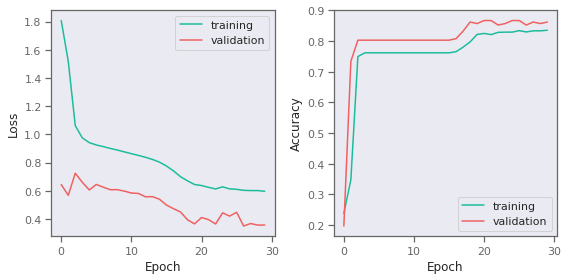

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(result.history['loss'], label='training')
ax1.plot(result.history['val_loss'], label='validation')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(result.history['accuracy'], label='training')
ax2.plot(result.history['val_accuracy'], label='validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
fig.tight_layout()
fig.savefig('gnn-loss-acc.png',dpi=180)
fig.show()


In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

prediction = []
test_y = []

for x,y in test_data.as_numpy_iterator():
    yhat = gcnmodel((x[0][np.newaxis,...], x[1][np.newaxis,...]))
    prediction.append(yhat.numpy())
    test_y.append(y)

prediction = np.array(prediction).flatten()
test_y = np.array(test_y)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, prediction)
auc_keras = auc(fpr_keras, tpr_keras)

for i, j in zip(test_y, prediction):
    print(i, j)

1.0 4.6046324
1.0 3.8385773
1.0 3.4485629
1.0 2.8776574
0.0 0.5367721
1.0 3.164987
1.0 2.4497714
0.0 -1.0848331
1.0 3.1500347
1.0 2.6766434
1.0 3.5931077
1.0 2.3486893
1.0 5.1918397
0.0 -0.5356505
1.0 2.584192
1.0 4.552384
1.0 1.4644058
0.0 -1.6767421
1.0 3.39331
0.0 -1.9891329
1.0 3.5368943
1.0 2.8811662
1.0 1.7836932
1.0 3.5920177
1.0 4.7805676
1.0 3.397418
1.0 2.5334198
0.0 2.5094666
1.0 3.382995
1.0 -0.43519783
1.0 3.527257
1.0 3.085281
1.0 3.3922746
1.0 3.9109683
1.0 2.1826737
1.0 2.5271232
1.0 3.347083
1.0 2.4253447
1.0 2.0822623
1.0 3.0277236
0.0 0.122185916
1.0 0.5212184
1.0 1.8358357
0.0 2.184299
0.0 2.0625699
1.0 2.6739542
1.0 1.4485105
1.0 3.3572
1.0 2.664852
1.0 3.781303
1.0 1.311131
1.0 3.702226
0.0 -0.4181962
1.0 2.8434508
0.0 -1.7715548
1.0 2.201087
1.0 2.065196
1.0 2.655398
1.0 2.8514917
0.0 -2.231646
1.0 3.4871173
1.0 2.5410168
1.0 2.1777487
0.0 3.4678285
0.0 -0.3479347
1.0 1.012627
0.0 -1.9843218
1.0 2.646177
1.0 3.808865
1.0 2.673954
1.0 3.0549223
0.0 1.4475578
1.0 3

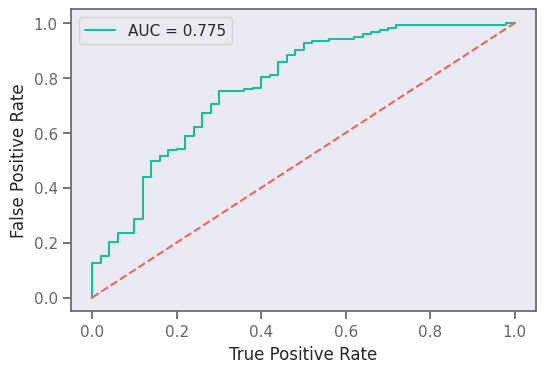

In [13]:
plt.figure(figsize=(6,4), dpi=100)
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend()
plt.savefig('gnn-roc.png',dpi=300)
plt.show()


## CF explanation

The following example find CFs for a given molecule where the BBBP activity is negative.

In [14]:
def predictor_function(smiles,selfies):
    #print('inut:',smiles)
    labels = []
    for sml in smiles:
        nodes, adj_mat = gen_smiles2graph(sml)
        pred = gcnmodel((nodes[np.newaxis,...], adj_mat[np.newaxis,...])).numpy()
        labels.append(pred)
        
    labels = np.array(labels).flatten()
    bin_labels =np.where(labels>0.5,np.ones(len(labels)),np.zeros(len(labels)))
    target_act = np.zeros(len(labels))
    return abs(bin_labels-target_act).astype(bool)

In [15]:
basic = exmol.get_basic_alphabet()
stoned_kwargs={'num_samples': 2500, 'alphabet':basic, 'max_mutations': 2}

In [16]:
%%time
example_base = toxdata.smiles[1000]
space = exmol.sample_space(example_base, predictor_function,stoned_kwargs=stoned_kwargs)

🤘Done🤘: 100%|██████████| 4010.0/4010 [00:29<00:00, 136.22it/s]              

CPU times: user 56.5 s, sys: 3.48 s, total: 60 s
Wall time: 53.9 s


In [17]:
for e in space:
    if e.yhat==True:
        e.yhat = 1
    elif e.yhat==False:
        e.yhat = 0

In [18]:
desc_type = 'MACCS'
space_tstats, beta = exmol.lime_explain(space, descriptor_type = desc_type)

In [40]:
beta

array([ 2.85461391e+01, -3.53090657e+01, -2.92783617e+01, -2.48960869e+01,
        4.95916083e+01,  3.13510213e+00,  2.01371018e+00,  3.62058257e+01,
        2.94946600e-02, -1.76227326e+01, -3.14798846e+01, -2.74372168e-02,
       -5.63442559e+00,  1.11012958e-02,  1.87494194e+00,  8.48829012e-04,
        3.58402956e-02, -1.28747914e-03, -2.39392669e+01, -5.24113590e-03,
        4.71224689e+01,  6.01523565e-02,  1.04253949e-02, -1.69138259e-02,
       -5.73863607e-02, -7.92263789e-03,  2.36273247e-03,  3.19533362e-02,
        2.55187534e-03,  2.50657506e-02, -2.80100983e-01, -2.03860043e-02,
        4.84169611e-02, -6.57849988e-02,  1.12395887e-02, -1.12688134e+01,
        1.68190944e-02, -1.26241198e-02, -6.51936012e-02, -8.21394135e-01,
       -9.10689620e-02, -1.96754460e-02,  2.94800639e-02, -2.51951355e-02,
        2.70920406e+01, -1.83227821e-02,  2.14599497e-02,  7.03946039e-02,
       -4.82650325e-03, -5.05007532e-03,  2.59893961e-02, -4.00784507e-01,
       -3.98058963e-02, -

In [19]:
def calc_ft_imp(space, space_tstats):
    from collections import OrderedDict
    feature_importance = {a:b for a, b in zip(space[0].descriptors.descriptor_names, space_tstats) if abs(b) > 2.96}
    feature_importance = dict(sorted(feature_importance.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
    #Fitted space important features
    return feature_importance

In [48]:
def plot_desc(feature_importance, desc_type, output_file, title=None, ax = None):
    from matplotlib.patches import Rectangle, FancyBboxPatch
    import textwrap
    t = list(feature_importance.values())
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    keys = list(feature_importance.keys())

    if len(t) > 0: 
        if len(t) > 5:
            t = t[:5]
            keys = keys[:5]
        elif len(t) < 5:
            diff = 5 - len(t)
            for i in range(diff):
                t.append(0)
                keys.append(' ')
        bar1 = ax.barh(range(len(t)), t, color=colors, height=0.75)
        new_patches = []
        for patch in reversed(ax.patches):
            bb = patch.get_bbox()
            color=patch.get_facecolor()
            p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                                abs(bb.width), abs(bb.height),
                                boxstyle="round,pad=-0.040,rounding_size=0.015",
                                ec="none", fc=color,
                                mutation_aspect=4
                                )
            patch.remove()
            new_patches.append(p_bbox)
        for patch in new_patches:
            ax.add_patch(patch)

        count = 1
        for rect, ti, k in zip(bar1, t, keys):
            y = rect.get_y() + rect.get_height()/2.
            if len(k) > 60:
                k = textwrap.fill(k, 30)
            elif len(k) > 25:
                k = textwrap.fill(k, 20)
            if ti < 0:
                x = 0.5
                ax.text(x, y, k, ha='left', va='center', wrap=True, fontsize=7)
                count+=1
            else:
                x = -0.5
                ax.text(x, y, k, ha='right', va='center', wrap=True, fontsize=7)
                count+=1
            
        ax.set_xlim(-max(t)-1, max(t)+1)
    else:
        ax.text(0.5, 0.5, 'No significant t-stats', ha='right', va='center', wrap=True, fontsize=7)
    
    
    ax.axvline(x=0, color='grey', linewidth=0.5)
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_xlabel('Feature t-statistics')
    ax.set_title(title)
    if output_file is not None:
        plt.savefig(output_file, dpi = 300, bbox_inches='tight')

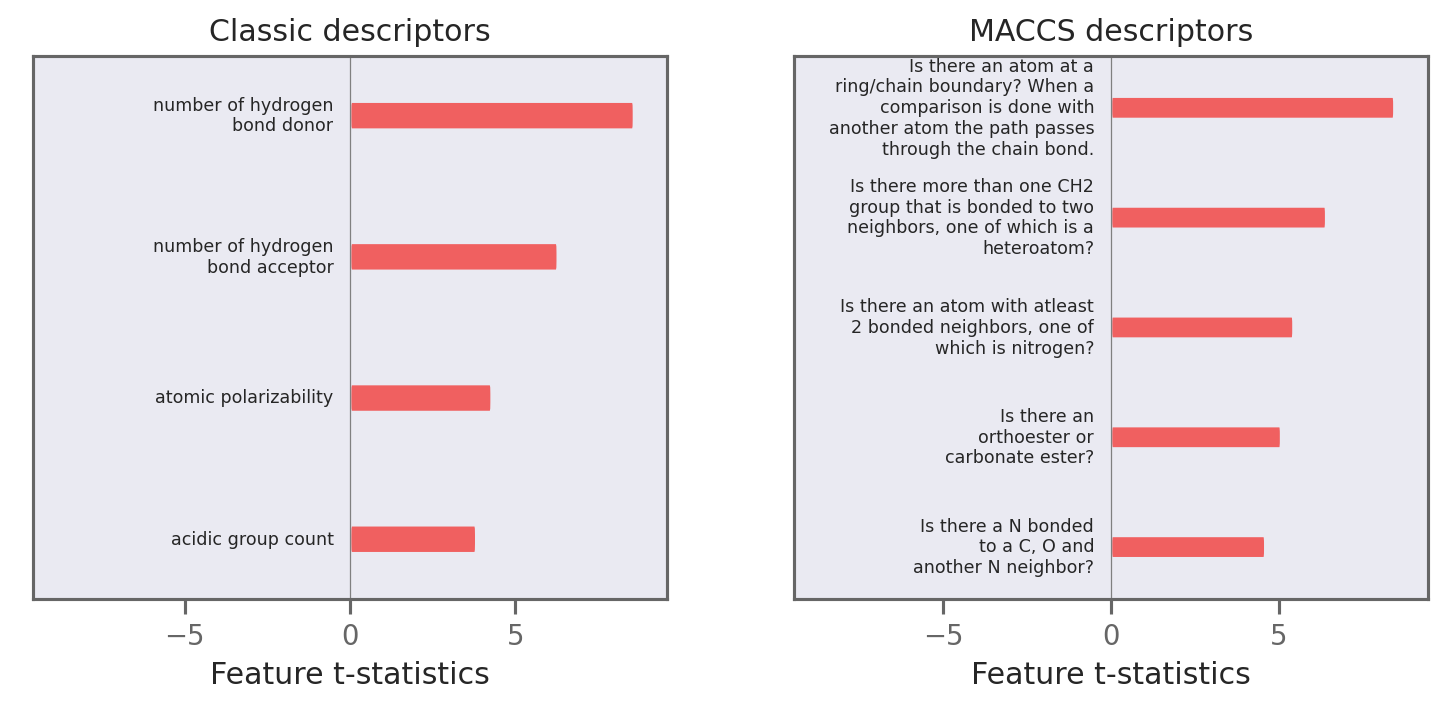

In [23]:
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator
desc_type = ['Classic', 'MACCS']
fig, ax = plt.subplots(nrows=1, ncols=len(desc_type), figsize=(10,4), dpi=180, squeeze=True)
i=0
for d in desc_type:
    space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
    feature_importance = calc_ft_imp(space, space_tstats)
    if len(feature_importance.items()) > 5:
        feature_importance = {a:feature_importance[a] for a in list(feature_importance.keys())[:5]}
    plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'{d} descriptors')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
    i+=1
plt.savefig(f'desc_gnn.png', dpi=180, bbox_inches='tight')
plt.show()

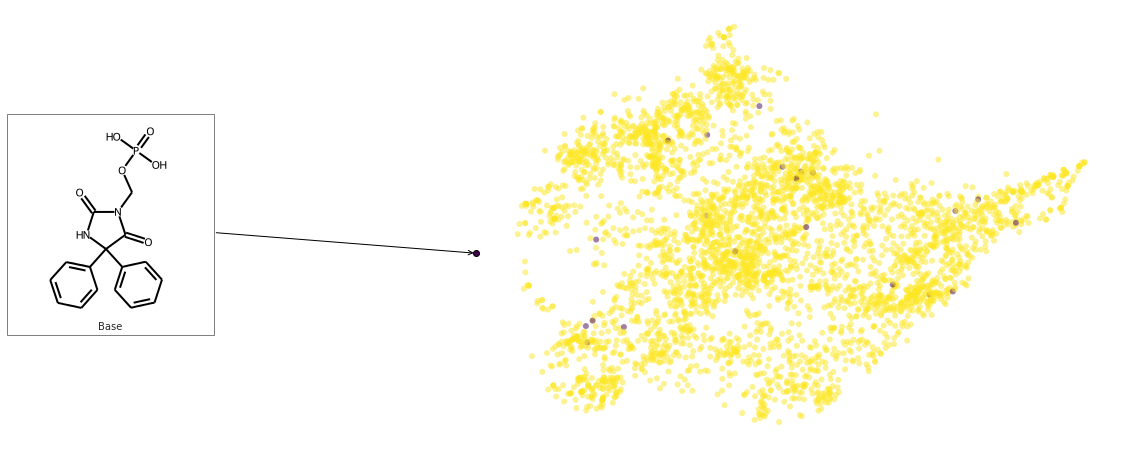

In [21]:
svg = exmol.plot_space(space, [space[0]])

In [55]:
exps = exmol.cf_explain(space,nmols=5)

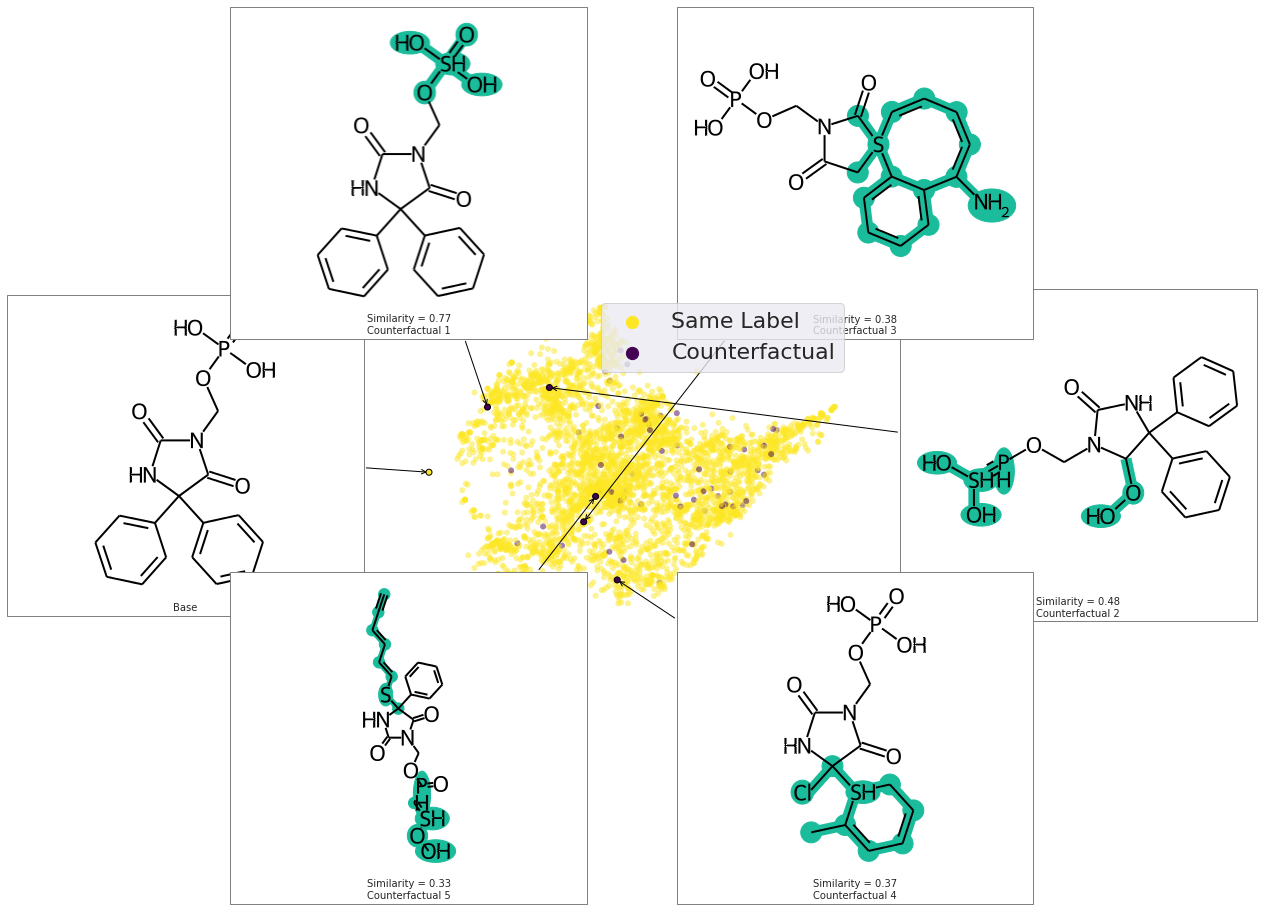

In [56]:
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

exmol.plot_space(space, exps, figure_kwargs=fkw, mol_size=(350,300),mol_fontsize=22)
plt.scatter([], [], label='Same Label', s=150, color=plt.get_cmap('viridis')(1.0))
plt.scatter([], [], label='Counterfactual', s=150, color=plt.get_cmap('viridis')(0.0))
plt.legend(fontsize=22)
plt.savefig('gnn-space.png', bbox_inches='tight', dpi=180)

## Effect of Mutations, alphabet and Size of space

In [36]:
# Mutation

smi = toxdata.smiles[1000]
tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic':[], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
muts = [1,3,5]

for i in muts:
    for d in desc_type:
        stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(),'min_mutations':i, 'max_mutations': i}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        spaces[d].append(space)    
        tstats[d].append(t)
#         print(tstats)
        beta[d].append(b)
#         print(beta)

🤘Done🤘: 100%|██████████| 1836.0/1836 [00:06<00:00, 291.27it/s]                      
🤘Done🤘: 100%|██████████| 1835.0/1835 [00:06<00:00, 291.80it/s]                      
🤘Done🤘: 100%|██████████| 2438.0/2438 [00:10<00:00, 226.72it/s]                     
🤘Done🤘: 100%|██████████| 2451.0/2451 [00:10<00:00, 223.86it/s]                     
🤘Done🤘: 100%|██████████| 2418.0/2418 [00:10<00:00, 234.15it/s]                     
🤘Done🤘: 100%|██████████| 2418.0/2418 [00:10<00:00, 234.63it/s]                     


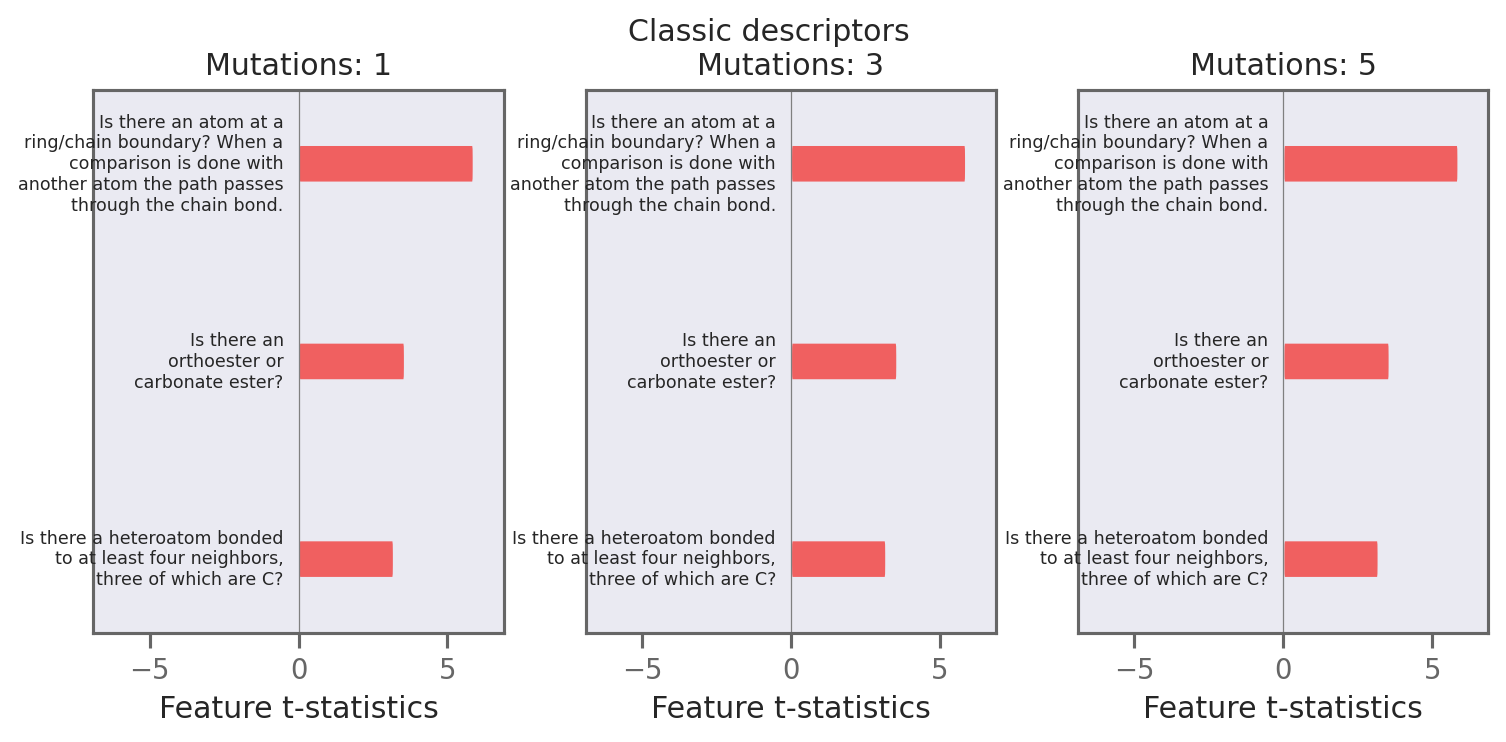

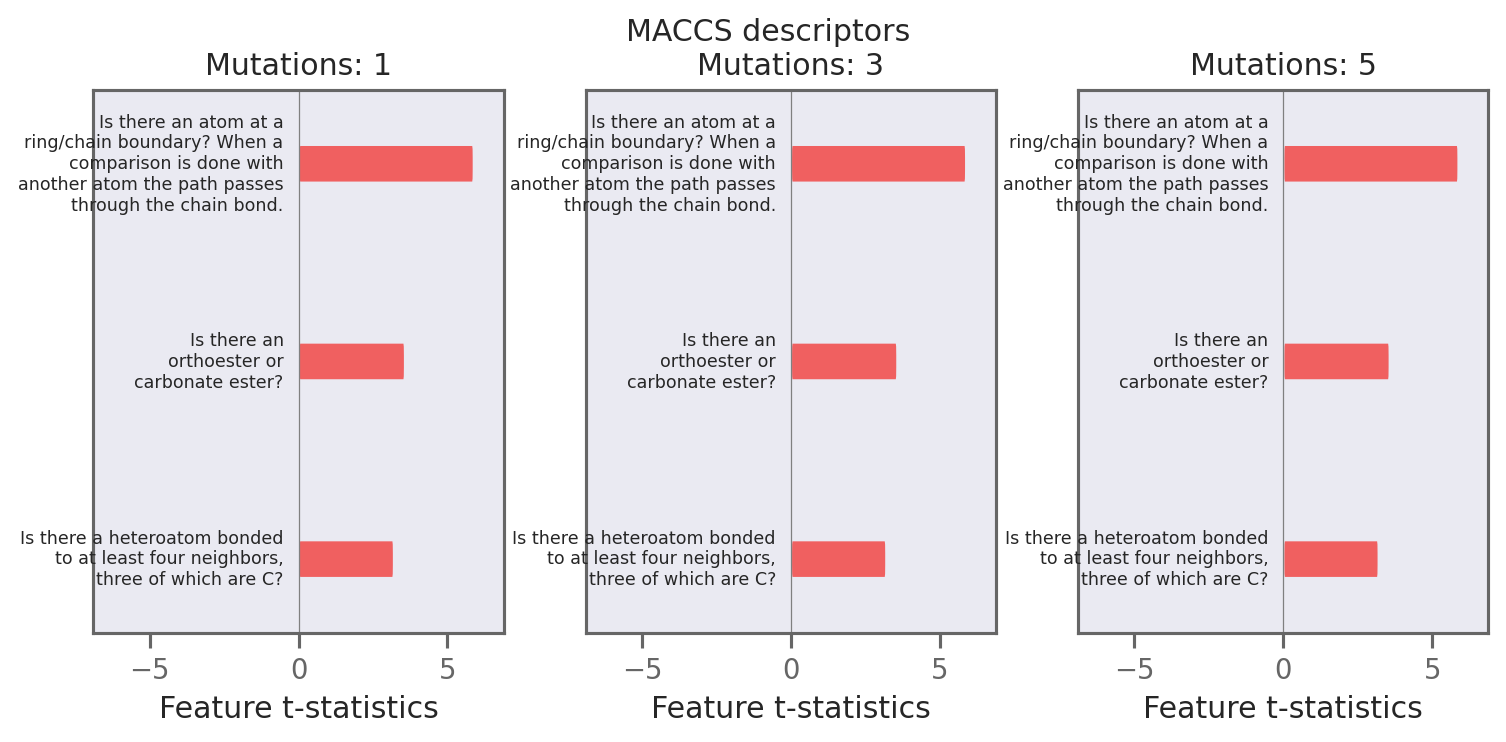

In [37]:
for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        if len(feature_importance.items()) > 5:
            feat = {a:feature_importance[a] for a in list(feature_importance.keys())[:5]}
            plot_desc(feat, d, output_file=None, 
                      ax=ax[i], title=f'Mutations: {muts[i]}')
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Mutations: {muts[i]}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_mutations.png', dpi=180, bbox_inches='tight')

In [42]:
len(spaces['Classic'][2])

2418

In [33]:
# Alphabet

tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic': [], 'MACCS': []}
basic = exmol.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()
desc_type = ['Classic', 'MACCS']
alphs = {'Basic': basic, 'Training Data': train, 'SELFIES': wide}

for a in alphs:
    for d in desc_type:
        stoned_kwargs={'num_samples': 2500, 'alphabet':alphs[a],'max_mutations':2}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        spaces[d].append(space)
        print(d)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        tstats[d].append(t)
        beta[d].append(b)

NameError: name 'selfies_list' is not defined

In [ ]:
akeys = list(alphs.keys())

for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        if len(feature_importance.items()) > 5:
            feat = {a:feature_importance[a] for a in list(feature_importance.keys())[:5]}
            plot_desc(feat, d, output_file=None, 
                      ax=ax[i], title=f'Alphabet: {akeys[i]}')
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Alphabet: {akeys[i]}')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_alphabet.png', dpi=180, bbox_inches='tight')

In [43]:
# Size of space

tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic': [], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
space_size = [1500, 2000, 2500]

for a in space_size:
    for d in desc_type:
        stoned_kwargs={'num_samples': a, 'alphabet': exmol.get_basic_alphabet(),'max_mutations':2}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        spaces[d].append(space)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        tstats[d].append(t)
        beta[d].append(b)

🤘Done🤘: 100%|██████████| 2526.0/2526 [00:11<00:00, 215.74it/s]              
🤘Done🤘: 100%|██████████| 2518.0/2518 [00:11<00:00, 217.03it/s]              
🤘Done🤘: 100%|██████████| 3293.0/3293 [00:19<00:00, 165.78it/s]              
🤘Done🤘: 100%|██████████| 3287.0/3287 [00:19<00:00, 165.89it/s]              
🤘Done🤘: 100%|██████████| 4079.0/4079 [00:30<00:00, 135.30it/s]              
🤘Done🤘: 100%|██████████| 4001.0/4001 [00:29<00:00, 137.22it/s]              


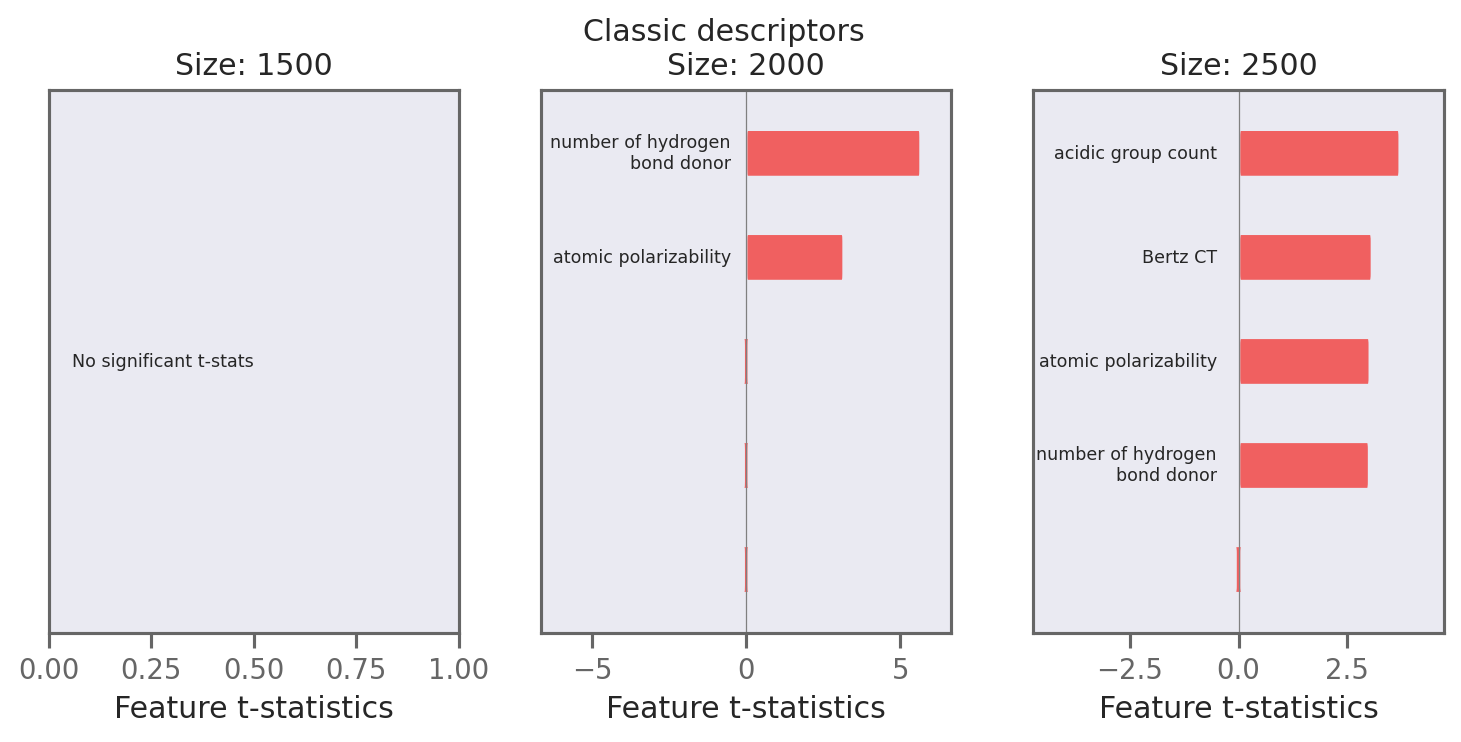

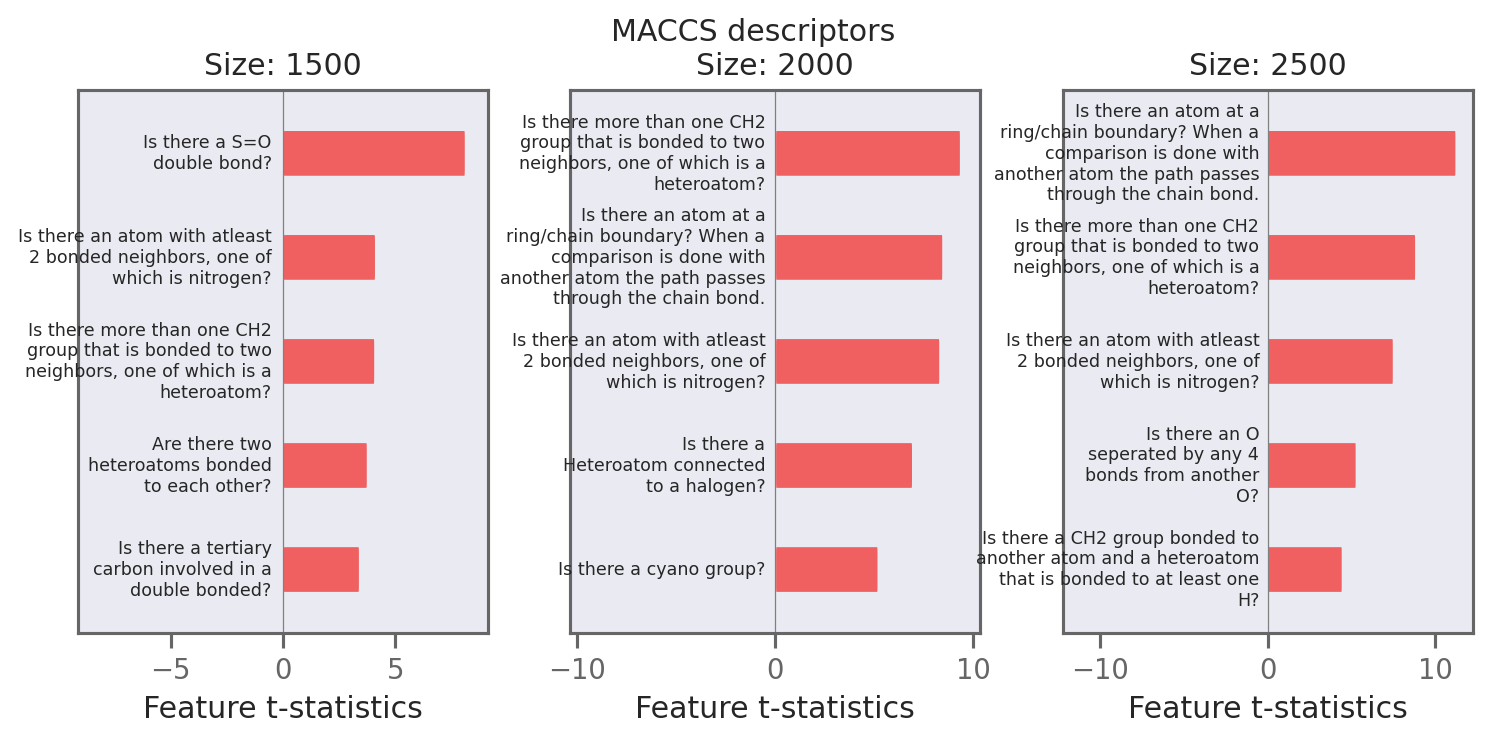

In [58]:
for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        feat = dict(sorted(feature_importance.items(),
                        key=lambda item: abs(item[1]),
                        reverse=True))
        feat = {a:feature_importance[a] for a in list(feature_importance.keys())[:5]}
            
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Size: {space_size[i]}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_size.png', dpi=180, bbox_inches='tight')

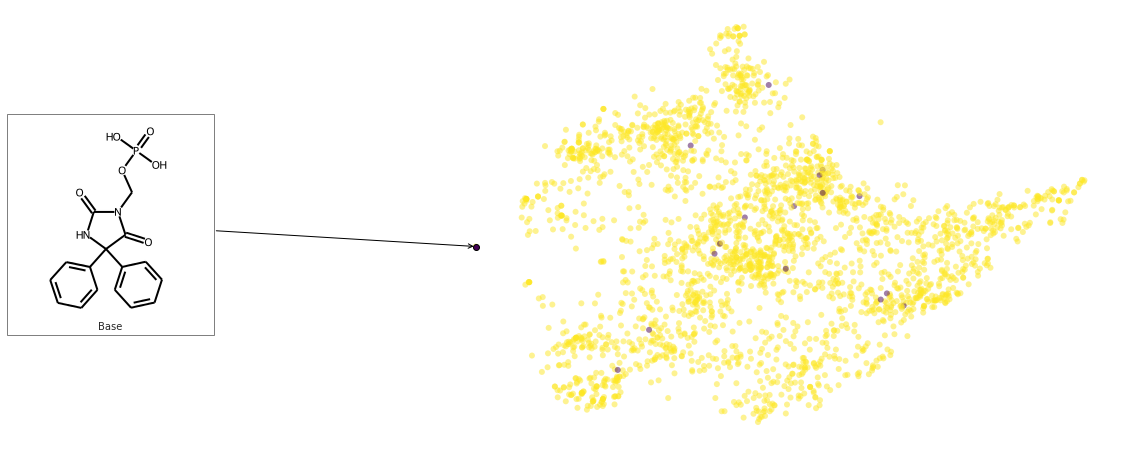

In [56]:
svg = exmol.plot_space(spaces[d][0], [spaces[d][0][0]])